# Overview

> You may wish to make a copy of this notebook to avoid overwriting the original.

This drawdown integration connects solutions that impact or are impacted by waste production.  _More about this here_


In [1]:
import sys
sys.path.append('../')   # If you move this notebook to another location, change this path to point to the root directory of the solutions project
import pandas as pd
from pathlib import Path
from integrations import integration_base as base
from integrations import waste_integration as wi

# This is an optional step to make floating point numbers display more compactly.
# If you prefer other options, you can change or delete this without harm.
pd.set_option('display.float_format', lambda x: f"{x:03.5f}".rstrip('0'))

# Inputs
<a href='inputs'></a>

The solutions used by this integration are listed below, with the scenarios currently chosen.  If these are not the appropriate scenarios to use, be sure to update them either in the notebook here, or in `integration_base.py`

In [2]:
for s in ['bioplastic','composting','hcrecycling','insulation','landfillmethane','recycledpaper','wastetoenergy']:
    print(f"{s}: {base.scenario_names[s]}")

bioplastic: ['PDS1', 'PDS2', 'PDS3']
composting: ['PDS1', 'PDS2', 'PDS3']
hcrecycling: ['PDS1', 'PDS2', 'PDS3']
insulation: ['PDS1', 'PDS2', 'PDS3']
landfillmethane: ['PDS1', 'PDS2', 'PDS3']
recycledpaper: ['PDS1', 'PDS2', 'PDS3']
wastetoenergy: ['PDS1', 'PDS2', 'PDS3']


Scenarios named 'PDS1', 'PDS2', and 'PDS3' refer to the most recent set of 'official' scenarios in each category as defined by the solution.  If a different set of scenarios should be used for integration, they can be set like this:

In [9]:
# base.scenario_names['bioplastic'] = ["name of PDS1 scenario", "name of PDS2 scenario", "name of PDS3 scenario"]

# Integration

Initialize integration with **<u>one</u>** of the following two steps:

In [3]:
# If you are beginning a *new* integration, or starting over

base.integration_clean()
base.integration_start()

In [2]:
# If you are continuing an *existing* integration process

base.integration_start()

Some integrations require multiple steps, but the waste integration can be done in a single pass:

In [4]:
wi.integrate()

compost adoption adjusted for 26/141 items by max 461.3709499795839
paper available feedstock adjusted for 141/141 items by max 164.75739145946568
paper consumption adjusted for 52/141 items by max 134.32478104384097
insulation consumption adjusted for 22/141 items by max 17.29156247
wte consumption adjusted for 118/141 items by max 1137.350578099259
lm adoption adjusted for 2/141 items by max 23.53
updating composting adoption
updating recycling adoption
updating waste to energy LHV values
updating landfill methane DOC values


At any time, you can delete the results of the integration by using `base.integration_clean()`.

In [10]:
#base.integration_clean()

> **Important**  Any time you run an integration, or run `integration_clean()` after running an integration, you must restart the Python process to cause the updated (or cleaned) models to reload.  You can do that within Jupyter notebook by selecting `Kernel>Restart` from the command menu, or clicking on the circle-arrow button.

# Checking out the Intermediate Results

When the integration process runs, intermediate (and final) results are captured in an audit log.  You can see what is in the log like this:

In [4]:
base.show_log()

-----------------------
waste
                     waste tam: (47, 3): [1773.333333 1773.333333 1773.333333]
                  base organic: (47, 3): [804.14197532 804.14197532 804.14197532]
               base recyclable: (47, 3): [627.40533322 627.40533322 627.40533322]
                base remainder: (47, 3): [341.78602447 341.78602447 341.78602447]
     organic less reduced food: (47, 3): [804.14197532 804.14197532 804.14197532]
   organic plus compostable bp: (47, 3): [804.79494532 804.79494532 804.79494532]
 recylable less compostable bp: (47, 3): [626.75236322 626.75236322 626.75236322]
         base compost adoption: (47, 3): [89.275 89.275 89.55 ]
     adjusted compost adoption: (47, 3): [89.275 89.275 89.55 ]
     organics msw less compost: (47, 3): [715.51994532 715.51994532 715.24494532]
       base recycling adoption: (47, 3): [206.02941101 206.02941101 206.02941101]
   adjusted recycling adoption: (47, 3): [206.02941101 206.02941101 206.02941101]
 recyclable msw less recy

And you can access any of the results with `base.get_logitem`.  The result is a pandas DataSeries or DataFrame, which you can print, analyze, plot...

In [11]:
paper_consumption = base.get_logitem("paper consumption")
paper_consumption.head(10)

,PDS1,PDS2,PDS3
Year,,,
2014,268.41,268.41,230.88897
2015,278.35576,296.06247,254.6759
2016,288.45107,307.93993,264.89301
2017,298.77627,320.3188,275.54144
2018,309.33687,333.22776,286.64586
2019,320.13839,346.69632,298.23165
2020,331.18635,359.39098,333.4772
2021,342.48628,372.55204,346.55294
2022,354.04369,386.20042,360.25831


<AxesSubplot:xlabel='Year'>

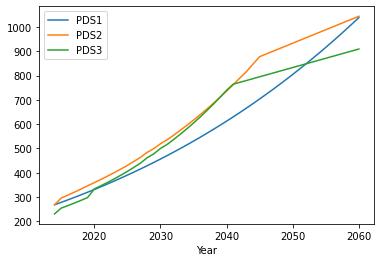

In [12]:
paper_consumption.plot()

<hr/>

### Developer Notes

> The remainder of this notebook is notes of the developer, and can be ignored.

Analysis of formula references:
```
    (PDS1, PDS2, PDS3) <--> (WTE Tonnes & Composition, Paper, Compost, Recycling)
    (PDS1, PDS2, PDS3) <-- Food System Summary
    PDS1 <--> Bioplastics
    (WTE Tonnes & Composition <--> WTE and LM Analysis <--> Landfill Methane)  <-- (PDS1, PDS2, PDS3)
    Refrigerant Management  <-->  None
```
That is, PDS1,2,3 are both input and output for the topic tabs, and the Waste & Landfill Methand tabs are a tightly bound cluster.  Refrigerant Management is isolated, as are all the background sheets, and the MSW TAM Update.

For some reason Bioplastics are tied only with PDS1?

The instruction document is quite detailed and helpful.  We'll mostly follow along.

Later notes:  I started out using openpyxl and SMAs to save things to files, and ended up just manually creating CSV files instead, as it was simpler.

Testing: by creating test snapshots of input data, you can then compare outputs (from the audit log) against the Excel.
I usually do this by cut and paste of Jupyter printout into a spare Excel tab, where I can do side-by-side comparison.

In [1]:
import sys
sys.path.append('../')   # If you move this notebook to another location, change this path to point to the root directory of the solutions project
import pandas as pd
from pathlib import Path
from integrations import integration_base as base
from integrations import waste_integration as wi

# This is an optional step to make floating point numbers display more compactly.
# If you prefer other options, you can change or delete this without harm.
pd.set_option('display.float_format', lambda x: f"{x:03.5f}".rstrip('0'))
base.integration_start(True)